### Matching month-to-month CPS observations

Updated: August 10, 2020

Brian Dew, @bd_econ


See: https://www.nber.org/papers/t0247

In [1]:
import pandas as pd
import os

os.chdir('/home/brian/Documents/CPS/data/clean')

In [2]:
# Identify which months should be matched
date_list = [(date_val.year, date_val.month) for date_val in 
             pd.date_range(start='1989-02-01', end='2020-11-01', freq='MS')]

date_pairs = list(zip(date_list, date_list[1:]))

start_year = date_pairs[0][0][0]

# Keep only the bd CPS columns needed for the analysis
keep_cols = ['CPSID', 'PULINENO', 'AGE', 'FEMALE', 'WBHAO', 'BASICWGT',
             'YEAR', 'MONTH', 'LFS']

def read_year(year):
    df = (pd.read_feather(f'cps{year}.ft', columns=keep_cols)
            .query('BASICWGT > 0 and CPSID > 0'))
    return df

In [3]:
# Match data and calculate flow
results = pd.Series(dtype='float64')

df1 = read_year(start_year)
df2 = df1

# Handle the case where the second match month is the following year
for (year1, month1), (year2, month2) in date_pairs:
    if month2 == 1:
        df2 = read_year(year2)
    if month1 == 1 and year1 > start_year:
        df1 = df2
        
    # Filter annual data to keep only revelant month's data
    d1 = df1.loc[df1['MONTH'] == month1]
    d2 = df2.loc[(df2['MONTH'] == month2) & 
                 (df2['LFS'] == 'Employed')]
    
    # Combine the two months and check that the person matches
    m = pd.merge(d1, d2, on=['CPSID', 'PULINENO'], how='inner')
    m = m[(m['WBHAO_x'] == m['WBHAO_y']) &
          (m['FEMALE_x'] == m['FEMALE_y']) &
          (m['AGE_y'] >= m['AGE_x']) &
          (m['AGE_x'] <= m['AGE_y'] + 1)]
    
    # Calculate the newly employed total and share that were NILF
    emp = m.loc[m['LFS_x'] != 'Employed', 'BASICWGT_y'].sum()
    nilf = m.loc[m['LFS_x'] == 'NILF', 'BASICWGT_y'].sum()
    
    # Store results in dataframe
    date = pd.to_datetime(f'{year2}-{month2}-01')
    if emp > 0:
        results[date] = (nilf / emp) * 100
    else:
        results[date] = None

### Plot result

In [4]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', edgecolor='white') # Hide the axes
plt.rc('axes', axisbelow=True)

# Recession start and end months, from NBER
rec_dt = [('1990-07-01', '1991-03-31'), 
          ('2001-03-01', '2001-11-30'), 
          ('2007-12-01', '2009-06-30'),
          ('2020-03-01', '2020-12-01')]

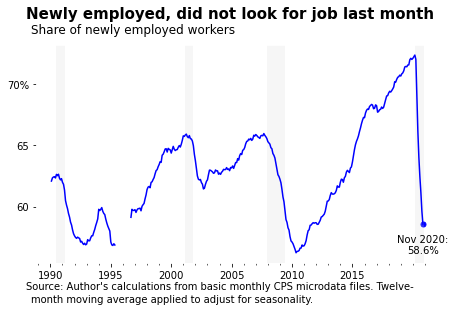

In [5]:
# Set plot details and plot data
offset = pd.DateOffset(months=4)
result = results.rolling(12).mean()
date_text = result.index[-1].strftime('%b %Y')
val_text = f'{round(result[-1], 1)}%'
result.plot(color='blue', legend=None, figsize=(7, 4), zorder=2)
plt.xlim(result.index[0] - offset, result.index[-1] + offset)

# Add recession bars
for i, v in rec_dt:
    ax = plt.axvspan(i, v, fill=True, linewidth=0, color='lightgray', 
                     alpha=0.2, zorder=1)
    
# Endpoint dot and label
plt.scatter([result.index[-1]], [result.iloc[-1]], color='blue', s=25)
plt.text(result.index[-1], result.iloc[-1] - 2.4, 
         f'{date_text}:\n{val_text}', ha='center')

# Axis labels
plt.yticks([60.0, 65.0, 70.0], ['60', '65', '70%'])
plt.xticks(['1990-01-01', '1995-01-01', '2000-01-01', '2005-01-01', 
            '2010-01-01', '2015-01-01'], 
           ['1990', '1995', '2000', '2005', '2010', '2015'], 
           ha='center', rotation=0) 

# Title and footer
plt.text('1988-01-01', result.max() + 3, 
         'Newly employed, did not look for job last month', 
          fontsize=15, weight='bold')
plt.text('1988-06-01', result.max() + 1.8, 
         "Share of newly employed workers", 
          fontsize=12)
plt.text('1988-01-01', result.min() - 3, 
         "Source: Author's calculations from basic monthly CPS microdata files. Twelve-")
plt.text('1988-06-01', result.min() - 4, 
         'month moving average applied to adjust for seasonality.')

plt.show()